In [ ]:
!pip install transformers

In [ ]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.3

In [1]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig

2024-01-24 17:19:05.855613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 17:19:08.898287: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-01-24 17:19:08.898432: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-01-24 17:19:08.905888: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-01-24 17:19:16.014649: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 2 compatible adapters.


In [2]:
myDir = "/mnt/c/Users/hisay/Downloads/"
myParquet = myDir + "/amazon_reviews_2015.snappy.parquet"

os.environ['CUDA_VISIBLE_DEVICE'] = '-1'

In [ ]:
# Define the connection between Input data and Label

In [3]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [4]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # トレーニング時には並列読み出しとシャッフルを行う。
    # 評価時にはシャッフルは行わず、並列読み出しは効果がない。

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [6]:
# train_data = "./data-tfrecord/bert-train"
train_data_filenames = myDir + "/train_data_small.tfrecord"
print("train_data_filenames {}".format(train_data_filenames))

train_dataset = file_based_input_dataset_builder(
    channel="train", 
    input_filenames=train_data_filenames, 
    max_seq_length=64, 
    is_training=True, 
    drop_remainder=False
).map(select_data_and_label_from_record)

train_data_filenames /mnt/c/Users/hisay/Downloads//train_data_small.tfrecord


2024-01-24 17:19:46.152675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 17:19:46.153668: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA Quadro P1000)
2024-01-24 17:19:47.232864: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) HD Graphics 630)
2024-01-24 17:19:47.292506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 17:19:47.292533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Yo

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [7]:
print(train_dataset)

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [8]:
# validation_data = "./data-tfrecord/bert-validation"
validation_data_filenames = myDir + "/validation_data_small.tfrecord"
print("validation_data_filenames {}".format(validation_data_filenames))

validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data_filenames,
    max_seq_length=64,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

validation_data_filenames /mnt/c/Users/hisay/Downloads//validation_data_small.tfrecord


In [9]:
epochs = 1
steps_per_epoch = 1
validation_steps = 1
test_steps = 1
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
max_seq_length = 64

In [10]:
CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.37.0",
  "vocab_size": 30522
}



In [ ]:
# Adding the layer for fine tuning on BERT

In [11]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.distilbert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Set up the custom classifier model

In [12]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 distilbert (TFDistilBertMainLa  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 yer)                           ast_hidden_state=(N               'input_mask[0][0]']             
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
callbacks = []

log_dir = "./tmp/tensorboard/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [15]:
with tf.device('/device:GPU:1'):
    history = model.fit(
        train_dataset,
        shuffle=True,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        callbacks=callbacks,
    )

/home/hisayuki/.local/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-24 17:20:27.254212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-24 17:20:28.896703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 17:20:28.896750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 17:20:28.896778: I tensorflow/core/common_runtime/pluggable_

1/1 [==============================] - ETA: 0s - loss: 1.6398 - accuracy: 0.3750

2024-01-24 17:20:34.721922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-24 17:20:35.235333: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 17:20:35.235384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-24 17:20:35.235414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17834 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-01-24 17:20:35.235429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

1/1 [==============================] - 17s 17s/step - loss: 1.6398 - accuracy: 0.3750 - val_loss: 1.9123 - val_accuracy: 0.1250


In [16]:
epochs = 256
steps_per_epoch = 32
validation_steps = 32
test_steps = 32
freeze_bert_layer = True
learning_rate = 3e-3
epsilon = 1e-08
max_seq_length = 64

In [17]:
with tf.device('/device:GPU:1'):
    history = model.fit(
        train_dataset,
        shuffle=True,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_dataset,
        validation_steps=validation_steps,
        callbacks=callbacks,
    )

Epoch 1/256
32/32 [==============================] - 102s 3s/step - loss: 1.6770 - accuracy: 0.1719 - val_loss: 1.6487 - val_accuracy: 0.2148
Epoch 2/256
32/32 [==============================] - 110s 3s/step - loss: 1.6326 - accuracy: 0.2266 - val_loss: 1.6201 - val_accuracy: 0.2227
Epoch 3/256
32/32 [==============================] - 119s 4s/step - loss: 1.6368 - accuracy: 0.2109 - val_loss: 1.6075 - val_accuracy: 0.2383
Epoch 4/256
32/32 [==============================] - 102s 3s/step - loss: 1.6212 - accuracy: 0.2578 - val_loss: 1.6002 - val_accuracy: 0.2383
Epoch 5/256
32/32 [==============================] - 104s 3s/step - loss: 1.6220 - accuracy: 0.1992 - val_loss: 1.5942 - val_accuracy: 0.2344
Epoch 6/256
32/32 [==============================] - 104s 3s/step - loss: 1.5876 - accuracy: 0.2617 - val_loss: 1.5914 - val_accuracy: 0.2422
Epoch 7/256
32/32 [==============================] - 104s 3s/step - loss: 1.6176 - accuracy: 0.2188 - val_loss: 1.5856 - val_accuracy: 0.2656
Epoch 

32/32 [==============================] - 56s 2s/step - loss: 1.3063 - accuracy: 0.4180 - val_loss: 1.1699 - val_accuracy: 0.4883
Epoch 231/256
32/32 [==============================] - 56s 2s/step - loss: 1.2585 - accuracy: 0.4375 - val_loss: 1.1735 - val_accuracy: 0.4961
Epoch 232/256
32/32 [==============================] - 56s 2s/step - loss: 1.2706 - accuracy: 0.4180 - val_loss: 1.1754 - val_accuracy: 0.5039
Epoch 233/256
32/32 [==============================] - 56s 2s/step - loss: 1.3189 - accuracy: 0.4062 - val_loss: 1.1809 - val_accuracy: 0.4922
Epoch 234/256
32/32 [==============================] - 56s 2s/step - loss: 1.2161 - accuracy: 0.4844 - val_loss: 1.1715 - val_accuracy: 0.4922
Epoch 235/256
32/32 [==============================] - 56s 2s/step - loss: 1.2703 - accuracy: 0.4375 - val_loss: 1.1716 - val_accuracy: 0.4922
Epoch 236/256
32/32 [==============================] - 56s 2s/step - loss: 1.3127 - accuracy: 0.3789 - val_loss: 1.1755 - val_accuracy: 0.4766
Epoch 237/256

In [18]:
print(history.history)

{'loss': [1.6769981384277344, 1.6326377391815186, 1.636797308921814, 1.6212352514266968, 1.6220064163208008, 1.5875694751739502, 1.6175665855407715, 1.5928179025650024, 1.5946831703186035, 1.598158836364746, 1.5878243446350098, 1.591509461402893, 1.5668468475341797, 1.5755183696746826, 1.567746639251709, 1.5754530429840088, 1.565755009651184, 1.59371018409729, 1.5599255561828613, 1.5640994310379028, 1.5484181642532349, 1.5293850898742676, 1.534197211265564, 1.5223116874694824, 1.5431382656097412, 1.525622844696045, 1.5321359634399414, 1.528223991394043, 1.5225389003753662, 1.5372473001480103, 1.4881654977798462, 1.5279079675674438, 1.5293234586715698, 1.4809784889221191, 1.481103539466858, 1.501165747642517, 1.4990943670272827, 1.4882937669754028, 1.4971165657043457, 1.4661345481872559, 1.4757375717163086, 1.4766360521316528, 1.437841773033142, 1.4639081954956055, 1.4745526313781738, 1.4475022554397583, 1.4617120027542114, 1.4867891073226929, 1.4131938219070435, 1.4369927644729614, 1.4

In [19]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [ ]:
# Adhoc predict

In [20]:
predict("This is great!")

/home/hisayuki/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-01-25 08:06:40.291776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-25 08:06:40.812776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-25 08:06:40.812826: I tensorflow/core/common_runtime/pluggable_d

1/1 [==============================] - 4s 4s/step


{'label': 5, 'socre': 0.8040823936462402}

In [21]:
predict("This is cool.")

1/1 [==============================] - 0s 180ms/step


{'label': 5, 'socre': 0.43505486845970154}

In [22]:
predict("I don't like this.")

1/1 [==============================] - 0s 177ms/step


{'label': 1, 'socre': 0.5807614326477051}

In [23]:
predict("I might buy it again.")

1/1 [==============================] - 0s 173ms/step


{'label': 3, 'socre': 0.3572377562522888}

In [24]:
predict("The color is a little bit different from the picture. But it is OK.")

1/1 [==============================] - 0s 167ms/step


{'label': 3, 'socre': 0.48809367418289185}

In [25]:
def plot_accracy(history):
    import matplotlib.pyplot as plt

    # Setting Parameters
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    # 1) Accracy Plt
    plt.plot(epochs, acc, 'bo' ,label = 'training accuracy')
    plt.plot(epochs, val_acc, 'b' , label= 'validation accuracy')
    plt.title('Training and Validation acc')
    plt.legend()

    plt.figure()

    # 2) Loss Plt
    plt.plot(epochs, loss, 'bo' ,label = 'training loss')
    plt.plot(epochs, val_loss, 'b' , label= 'validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

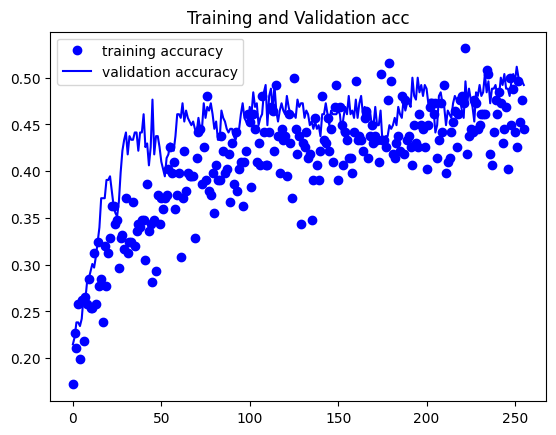

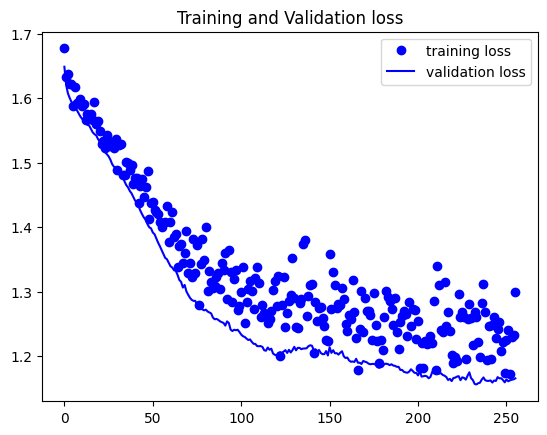

In [26]:
from keras import models 
from keras import layers
from keras import optimizers

#show Accuracy and Loss History
#「loss」と「val_loss」の違いですが、「loss」は学習時のlossの値で、正解と予測の差分です。この値を少なくするように学習を進めます。
#「val_loss」は検証用データでlossを計算した値です。
# モデルは「loss」の値を少なくするように学習データを使用して学習を進めます。ただし学習データのみを使用して学習するため、学習データのみ 
# にあてはまり新たなデータでうまく予測できなくなる、いわゆるオーバーフィッティング状態になることがあります。
# グラフ上では「loss」が下がっていくのに「val_loss」が上がってしまう状態です。
plot_accracy(history)

In [28]:
model.save(myDir + 'tensorflow_small/',save_format='tf')

INFO:tensorflow:Assets written to: /mnt/c/Users/hisay/Downloads/tensorflow_small/assets


INFO:tensorflow:Assets written to: /mnt/c/Users/hisay/Downloads/tensorflow_small/assets
